In [79]:
## load useful libraries
suppressWarnings(suppressPackageStartupMessages(library(rhdf5)))
suppressWarnings(suppressPackageStartupMessages(library(qvalue)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(ggbeeswarm)))
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
suppressWarnings(suppressPackageStartupMessages(library(scater)))
suppressWarnings(suppressPackageStartupMessages(library(SingleCellExperiment)))
suppressWarnings(suppressPackageStartupMessages(library(edgeR)))
suppressWarnings(suppressPackageStartupMessages(library(limma)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(ISLR)))
suppressWarnings(suppressPackageStartupMessages(library(GGally)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(ComplexHeatmap)))
suppressWarnings(suppressPackageStartupMessages(library(circlize)))

In [80]:
ase_folder = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/ase_env_interactions/selected_results_181023/"

In [81]:
test_filename = paste0(ase_folder,"pseudotimeandmodules.single_factor_test.all_leads.tsv")
pseudocorrect_filename = paste0(ase_folder,"pseudotimeandmodules.pseudotime_covariate_test.all_leads.tsv")
nonlinear_filename = paste0(ase_folder,"pseudotimeandmodules.combined_factor_test.all_leads.tsv")
quadratic_filename = paste0(ase_folder,"pseudotimeandmodules.quadratic_factor_test.all_leads.tsv")

In [82]:
test = read.csv(test_filename, sep = "\t")
pseudocorrect = read.csv(pseudocorrect_filename, sep = "\t")
nonlinear = read.csv(nonlinear_filename, sep = "\t")
quadratic = read.csv(quadratic_filename, sep = "\t")

In [83]:
clusters_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/ase_env_interactions/eqtl_clustering/cluster_significant_linear_psuedotime_ase_interactions_qval_0.01.tsv"

In [84]:
clusters = read.csv(clusters_filename, sep = "\t")
head(clusters)

gene_id,snp_id,exp_cluster_label,ase_cluster_label
ENSG00000035141,2_70502930_A_G,1,1
ENSG00000107968,10_30809648_T_G,3,1
ENSG00000172992,17_43095854_G_A,3,1
ENSG00000138061,2_38204219_C_G,3,1
ENSG00000006282,17_48619272_G_A,3,1
ENSG00000141655,18_59990654_C_T,2,1


In [85]:
gene_info_filename = "/nfs/leia/research/stegle/dseaton/genomes/hg19/annotation/Homo_sapiens.GRCh37.75.genes.bed"
gene_info = read.table(gene_info_filename)
colnames(gene_info) = c("chromosome_name","start_position","end_position","gene_id","gene_biotype","strand")
head(gene_info)

chromosome_name,start_position,end_position,gene_id,gene_biotype,strand
1,11868,14412,ENSG00000223972,pseudogene,+
1,14362,29806,ENSG00000227232,pseudogene,-
1,29553,31109,ENSG00000243485,lincRNA,+
1,34553,36081,ENSG00000237613,lincRNA,-
1,52472,54936,ENSG00000268020,pseudogene,+
1,62947,63887,ENSG00000240361,pseudogene,+


In [86]:
add_TSS_dist <- function(test){
    res = inner_join(test, gene_info, by = "gene_id")  
    snp_info = as_data_frame(do.call("rbind", lapply(strsplit(res$snp_id, "_"), function(x) t(as.data.frame(x)))))
    colnames(snp_info) = c("chrom","pos","ref_allele","alt_allele")
    res = cbind(res,snp_info)
    res$pos = as.numeric(res$pos)                                       
    res[res$strand == "+","TSS"] = res[res$strand == "+","start_position"]
    res[res$strand == "-","TSS"] = res[res$strand == "-","end_position"]
    res[res$strand == "+","dist"] = res[res$strand == "+","pos"] - res[res$strand == "+","TSS"]
    res[res$strand == "-","dist"] = - res[res$strand == "-","pos"] + res[res$strand == "-","TSS"]
    res
}

In [87]:
cluster0 = clusters[clusters$ase_cluster_label == "0",]
cluster1 = clusters[clusters$ase_cluster_label == "1",]
cluster2 = clusters[clusters$ase_cluster_label == "2",]
cluster3 = clusters[clusters$ase_cluster_label == "3",]

In [88]:
cluster0 = add_TSS_dist(cluster0)
cluster1 = add_TSS_dist(cluster1)
cluster2 = add_TSS_dist(cluster2)
cluster3 = add_TSS_dist(cluster3)

In [89]:
head(cluster0)

gene_id,snp_id,exp_cluster_label,ase_cluster_label,chromosome_name,start_position,end_position,gene_biotype,strand,chrom,pos,ref_allele,alt_allele,TSS,dist
ENSG00000165672,10_120920890_T_A,0,0,10,120927214,120938345,protein_coding,-,10,120920890,T,A,120938345,17455
ENSG00000143367,1_151501437_G_A,3,0,1,151512780,151556059,protein_coding,+,1,151501437,G,A,151512780,-11343
ENSG00000138759,4_78980923_G_A,3,0,4,78978723,79465423,protein_coding,+,4,78980923,G,A,78978723,2200
ENSG00000064042,4_41339317_C_T,2,0,4,41361623,41702061,protein_coding,+,4,41339317,C,T,41361623,-22306
ENSG00000103479,16_53538021_T_A,2,0,16,53467888,53525561,protein_coding,+,16,53538021,T,A,53467888,70133
ENSG00000214176,17_62801318_T_C,2,0,17,62775376,62833272,pseudogene,-,17,62801318,T,C,62833272,31954


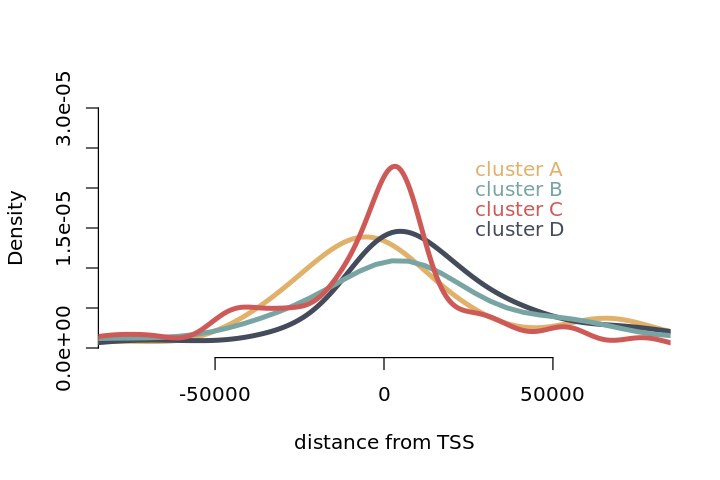

In [90]:
options(repr.plot.width = 6, repr.plot.height = 4)
x0 = cluster0$dist
x1 = cluster1$dist
x2 = cluster2$dist
x3 = cluster3$dist
canva = "Muted and antique"
canva = "Warm and cool"
col0 = canva_pal(canva)(4)[4]
col1 = canva_pal(canva)(4)[1]
col2 = canva_pal(canva)(4)[3]
col3 = canva_pal(canva)(4)[2]
hist(x0, breaks = 1000, border = "white", probability = T, xlim = c(min(x0),-min(x0)), col = "white", 
     ylim = c(0, 3e-5), xlab = "distance from TSS", main = "")
lines(density(x0), col = col0, lwd = 4)
lines(density(x1), col = col1, lwd = 4)
lines(density(x2), col = col2, lwd = 4)
lines(density(x3), col = col3, lwd = 4)
text(40000, 2.25e-5, "cluster A", col = col0)
text(40000, 2e-5, "cluster B", col = col2)
text(40000, 1.75e-5, "cluster C", col = col3)
text(40000, 1.5e-5, "cluster D", col = col1)

In [91]:
canva = "Warm and cool"
canva_pal(canva)(4)

[1] "#444c5c" "#ce5a57" "#78a5a3" "#e1b16a"

In [92]:
clusters$exp_cluster_label

[1] 1 3 3 3 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 3 3 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 2 2 2 1 2 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1
[112] 1 0 1 1 1 1 1 1 0 3 3 2 2 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 2 0 0 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 3 3 2 3 3 3 3 3 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 2 2 2 2 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[223] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1
[260] 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 1 1 1 1
[297] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2

In [93]:
eQTL_histones_filename <- "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/qtl_chipseq_overlaps/all_qtl_results_combined.overlap_w_vallier_histone_marks.tsv"
eQTL_histones <- read.csv(eQTL_histones_filename, sep = "\t")
head(eQTL_histones)

snp_id,Unnamed..0,beta.mean,beta_se,empirical_feature_p_value,p_value.mean,snp_id.1,feature,global_corr_p_value,chrom,⋯,H3K4me3,H3K4me3_h0,H3K4me3_h24,H3K36me3_h48,H3K36me3_h24,H3K36me3_h36,H3K36me3_h72,H3K36me3_h0,H3K36me3_h12,H3K36me3
6_31132414_G_A,24,-1.386281,0.1083733,1.592971e-18,1.823854e-37,6_31132414_G_A,ENSG00000204531_POU5F1,5.264237e-16,6,⋯,False,False,False,True,True,True,True,True,True,True
6_32634922_A_G,117,-1.270786,0.1469673,1.977147e-11,5.299864e-18,6_32634922_A_G,ENSG00000179344_HLA-DQB1,1.340269e-09,6,⋯,False,False,False,False,False,False,False,False,False,False
6_32634922_A_G,1879,-1.375988,0.1478612,8.485500e-15,1.328104e-20,6_32634922_A_G,ENSG00000179344_HLA-DQB1,1.519887e-12,6,⋯,False,False,False,False,False,False,False,False,False,False
6_32634922_A_G,3587,-1.438379,0.1499301,3.298243e-12,8.500689e-22,6_32634922_A_G,ENSG00000179344_HLA-DQB1,5.981274e-10,6,⋯,False,False,False,False,False,False,False,False,False,False
9_136227260_A_G,20,-1.371767,0.1094063,1.461609e-19,4.608624e-36,9_136227260_A_G,ENSG00000148291_SURF2,5.796154e-17,9,⋯,False,False,False,True,True,True,True,True,True,True
9_136227260_A_G,1851,-1.410832,0.1143974,6.363028e-20,6.036677e-35,9_136227260_A_G,ENSG00000148291_SURF2,2.949861e-17,9,⋯,False,False,False,True,True,True,True,True,True,True


In [94]:
df.histones = eQTL_histones[, colnames(eQTL_histones) %in% c(colnames(eQTL_histones)[grep("H3K27ac_h",colnames(eQTL_histones))],
                                                             colnames(eQTL_histones)[grep("H3K4me1_h",colnames(eQTL_histones))],
                                                             colnames(eQTL_histones)[grep("H3K4me3_h",colnames(eQTL_histones))],
                                                             colnames(eQTL_histones)[grep("H3K36me3_h",colnames(eQTL_histones))],
                                                             colnames(eQTL_histones)[grep("H3K27me3_h",colnames(eQTL_histones))],
                                                             "snp_id","feature")]
df.histones$gene_id = gsub("*_.*", "", df.histones$feature)
df.histones$eQTL = paste0(df.histones$feature,"-",df.histones$snp_id)
df.histones = df.histones[-which(duplicated(df.histones$eQTL)),]
nrow(df.histones)
head(df.histones)

[1] 4470

,snp_id,feature,H3K27me3_h12,H3K27me3_h24,H3K27me3_h48,H3K27me3_h0,H3K27me3_h72,H3K27ac_h12,H3K27ac_h0,H3K27ac_h48,⋯,H3K4me3_h0,H3K4me3_h24,H3K36me3_h48,H3K36me3_h24,H3K36me3_h36,H3K36me3_h72,H3K36me3_h0,H3K36me3_h12,gene_id,eQTL
1,6_31132414_G_A,ENSG00000204531_POU5F1,False,False,False,False,False,False,False,False,⋯,False,False,True,True,True,True,True,True,ENSG00000204531,ENSG00000204531_POU5F1-6_31132414_G_A
2,6_32634922_A_G,ENSG00000179344_HLA-DQB1,False,False,False,False,False,False,False,False,⋯,False,False,False,False,False,False,False,False,ENSG00000179344,ENSG00000179344_HLA-DQB1-6_32634922_A_G
5,9_136227260_A_G,ENSG00000148291_SURF2,False,False,False,False,False,False,False,False,⋯,False,False,True,True,True,True,True,True,ENSG00000148291,ENSG00000148291_SURF2-9_136227260_A_G
8,16_31522723_T_C,ENSG00000169877_AHSP,False,False,False,False,False,False,False,False,⋯,False,False,False,False,False,False,False,False,ENSG00000169877,ENSG00000169877_AHSP-16_31522723_T_C
9,12_7945196_G_T,ENSG00000176654_NANOGP1,False,False,False,False,False,False,False,False,⋯,False,False,True,True,True,False,True,True,ENSG00000176654,ENSG00000176654_NANOGP1-12_7945196_G_T
10,10_122218993_G_A,ENSG00000203805_PPAPDC1A,False,False,False,False,False,False,False,True,⋯,False,False,False,False,False,False,False,False,ENSG00000203805,ENSG00000203805_PPAPDC1A-10_122218993_G_A


In [95]:
get_colsums <- function(eqtls.set, hist.mark){
    res.all = inner_join(eqtls.set, df.histones, by = c("snp_id","gene_id"))
    res = res.all[, grep(hist.mark, colnames(res.all))]
    res[res == "True"] = 1
    res[res == "False"] = 0
    df = as.data.frame(sapply(res, as.numeric))
    colsums = colSums(df)/nrow(df)
    colsums[order(names(colsums))]
}

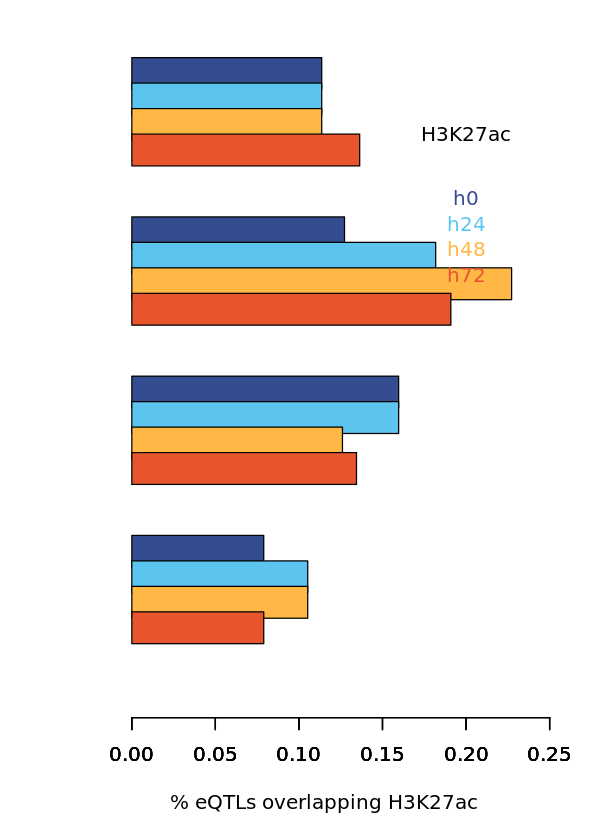

In [96]:
cluster0.ac = get_colsums(cluster0, "H3K27ac")
cluster1.ac = get_colsums(cluster1, "H3K27ac")
cluster2.ac = get_colsums(cluster2, "H3K27ac")
cluster3.ac = get_colsums(cluster3, "H3K27ac")

options(repr.plot.width = 5, repr.plot.height = 7)
h0 <- c(cluster0.ac[1], cluster1.ac[1], cluster2.ac[1], cluster3.ac[1])
h24 <- c(cluster0.ac[3], cluster1.ac[3], cluster2.ac[3], cluster3.ac[3])
h48 <- c(cluster0.ac[5], cluster1.ac[5], cluster2.ac[5], cluster3.ac[5])
h72 <- c(cluster0.ac[6], cluster1.ac[6], cluster2.ac[6], cluster3.ac[6])

my.xlim = c(-0.02,0.25)
my.space = 4

barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = "#344d90",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27ac", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = "#5cc5ef",
        ylim = c(0.4, 9.4), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = "#ffb745",
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = "#e7552c",
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(0.2, 10, "H3K27ac", col = "black")
text(0.2, 9, "h0", col = "#344d90")
text(0.2, 8.6, "h24", col = "#5cc5ef")
text(0.2, 8.2, "h48", col = "#ffb745")
text(0.2, 7.8, "h72", col = "#e7552c")

In [97]:
pseudo.linear.nonsign = get_nonsign(test, "pseudotime")
pseudo.linear.nonsign$gene_id = pseudo.linear.nonsign$ensembl_gene_id

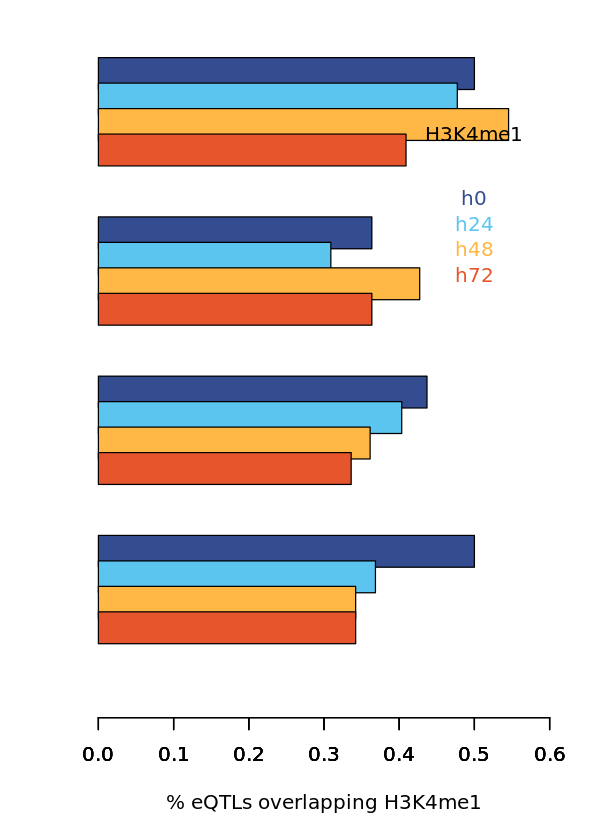

In [98]:
cluster0.ac = get_colsums(cluster0, "H3K4me1")
cluster1.ac = get_colsums(cluster1, "H3K4me1")
cluster2.ac = get_colsums(cluster2, "H3K4me1")
cluster3.ac = get_colsums(cluster3, "H3K4me1")
pseudo.linear.nonsign.ac = get_colsums(pseudo.linear.nonsign, "H3K4me1")

options(repr.plot.width = 5, repr.plot.height = 7)
h0 <- c(cluster0.ac[1], cluster1.ac[1], cluster2.ac[1], cluster3.ac[1])
h24 <- c(cluster0.ac[3], cluster1.ac[3], cluster2.ac[3], cluster3.ac[3])
h48 <- c(cluster0.ac[5], cluster1.ac[5], cluster2.ac[5], cluster3.ac[5])
h72 <- c(cluster0.ac[6], cluster1.ac[6], cluster2.ac[6], cluster3.ac[6])

my.xlim = c(0,0.6)
my.space = 4

barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = "#344d90",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K4me1", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = "#5cc5ef",
        ylim = c(0.4, 9.4), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = "#ffb745",
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = "#e7552c",
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(0.5, 10, "H3K4me1", col = "black")
text(0.5, 9, "h0", col = "#344d90")
text(0.5, 8.6, "h24", col = "#5cc5ef")
text(0.5, 8.2, "h48", col = "#ffb745")
text(0.5, 7.8, "h72", col = "#e7552c")

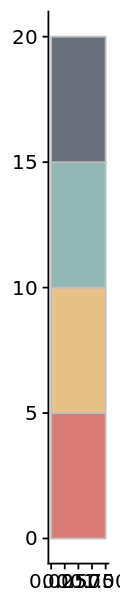

In [99]:
options(repr.plot.width = 1, repr.plot.height = 5)
p = ggplot()
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 0, ymax = 5), color = "grey", alpha = 0.8, fill = col3)
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 5, ymax = 10), color = "grey", alpha = 0.8, fill = col0)
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 10, ymax = 15), color = "grey", alpha = 0.8, fill = col2)
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 15, ymax = 20), color = "grey", alpha = 0.8, fill = col1)
p

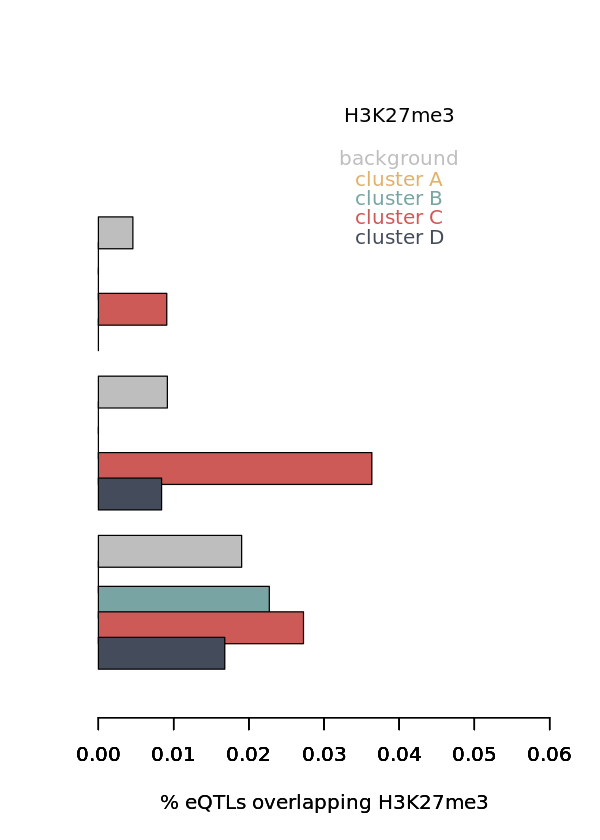

In [100]:
cluster0.ac = get_colsums(cluster0, "H3K27me3")
cluster1.ac = get_colsums(cluster1, "H3K27me3")
cluster2.ac = get_colsums(cluster2, "H3K27me3")
cluster3.ac = get_colsums(cluster3, "H3K27me3")
pseudo.linear.nonsign.ac = get_colsums(pseudo.linear.nonsign, "H3K27me3")

options(repr.plot.width = 5, repr.plot.height = 7)
non <- c(pseudo.linear.nonsign.ac[1],pseudo.linear.nonsign.ac[3],pseudo.linear.nonsign.ac[5],pseudo.linear.nonsign.ac[6])
h0 <- c(cluster0.ac[1], cluster0.ac[3], cluster0.ac[5], cluster0.ac[6])
h72 <- c(cluster1.ac[1], cluster1.ac[3], cluster1.ac[5], cluster1.ac[6])
h48 <- c(cluster2.ac[1], cluster2.ac[3], cluster2.ac[5], cluster2.ac[6])
h24 <- c(cluster3.ac[1], cluster3.ac[3], cluster3.ac[5], cluster3.ac[6])

xmax = 0.06
xtext = 0.04

my.xlim = c(0, xmax)
my.space = 4

barplot(as.numeric(non), 
#         border = "#344d90", 
        col = "grey",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27me3", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = col0,
        xlim = my.xlim, ylim = c(0.4,9.4), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27me3", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = col2,
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = col3,
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = col1,
        ylim = c(1.6, 10.6), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(xtext, 10.7, "H3K27me3", col = "black")
text(xtext, 10, "background", col = "grey")
text(xtext, 9.7, "cluster A", col = col0)
text(xtext, 9.4, "cluster B", col = col2)
text(xtext, 9.1, "cluster C", col = col3)
text(xtext, 8.8, "cluster D", col = col1)

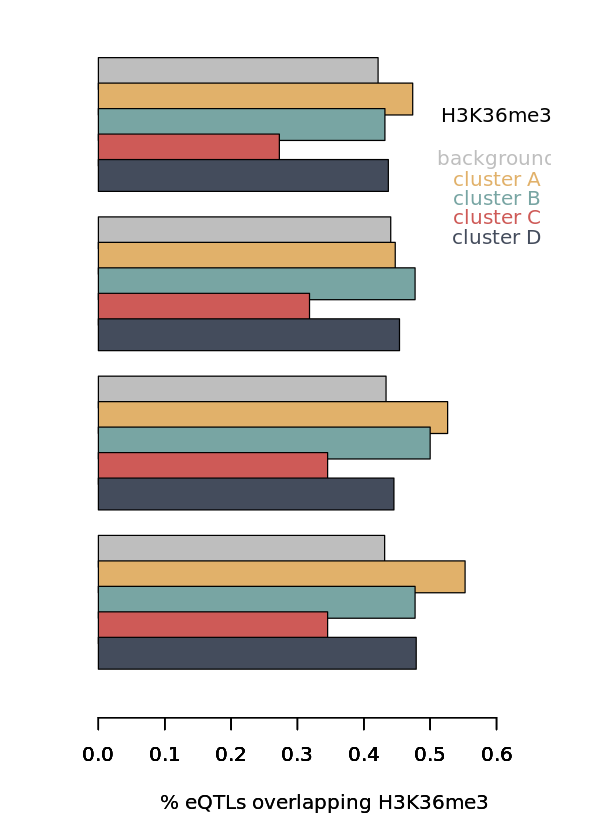

In [101]:
cluster0.ac = get_colsums(cluster0, "H3K36me3")
cluster1.ac = get_colsums(cluster1, "H3K36me3")
cluster2.ac = get_colsums(cluster2, "H3K36me3")
cluster3.ac = get_colsums(cluster3, "H3K36me3")
pseudo.linear.nonsign.ac = get_colsums(pseudo.linear.nonsign, "H3K36me3")

options(repr.plot.width = 5, repr.plot.height = 7)
non <- c(pseudo.linear.nonsign.ac[1],pseudo.linear.nonsign.ac[3],pseudo.linear.nonsign.ac[5],pseudo.linear.nonsign.ac[6])
h0 <- c(cluster0.ac[1], cluster0.ac[3], cluster0.ac[5], cluster0.ac[6])
h72 <- c(cluster1.ac[1], cluster1.ac[3], cluster1.ac[5], cluster1.ac[6])
h48 <- c(cluster2.ac[1], cluster2.ac[3], cluster2.ac[5], cluster2.ac[6])
h24 <- c(cluster3.ac[1], cluster3.ac[3], cluster3.ac[5], cluster3.ac[6])

xmax = 0.68
xtext = 0.6

my.xlim = c(0, xmax)
my.space = 4

barplot(as.numeric(non), 
#         border = "#344d90", 
        col = "grey",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K36me3", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = col0,
        xlim = my.xlim, ylim = c(0.4,9.4), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K36me3", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = col2,
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = col3,
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = col1,
        ylim = c(1.6, 10.6), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(xtext, 10.7, "H3K36me3", col = "black")
text(xtext, 10, "background", col = "grey")
text(xtext, 9.7, "cluster A", col = col0)
text(xtext, 9.4, "cluster B", col = col2)
text(xtext, 9.1, "cluster C", col = col3)
text(xtext, 8.8, "cluster D", col = col1)

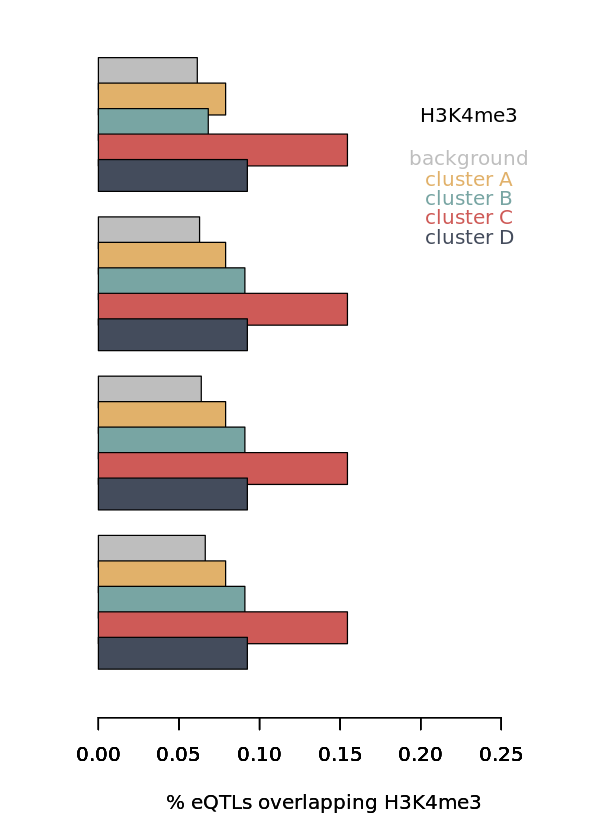

In [102]:
cluster0.ac = get_colsums(cluster0, "H3K4me3")
cluster1.ac = get_colsums(cluster1, "H3K4me3")
cluster2.ac = get_colsums(cluster2, "H3K4me3")
cluster3.ac = get_colsums(cluster3, "H3K4me3")
pseudo.linear.nonsign.ac = get_colsums(pseudo.linear.nonsign, "H3K4me3")

options(repr.plot.width = 5, repr.plot.height = 7)
non <- c(pseudo.linear.nonsign.ac[1],pseudo.linear.nonsign.ac[3],pseudo.linear.nonsign.ac[5],pseudo.linear.nonsign.ac[6])
h0 <- c(cluster0.ac[1], cluster0.ac[3], cluster0.ac[5], cluster0.ac[6])
h72 <- c(cluster1.ac[1], cluster1.ac[3], cluster1.ac[5], cluster1.ac[6])
h48 <- c(cluster2.ac[1], cluster2.ac[3], cluster2.ac[5], cluster2.ac[6])
h24 <- c(cluster3.ac[1], cluster3.ac[3], cluster3.ac[5], cluster3.ac[6])

xmax = 0.28
xtext = 0.23

my.xlim = c(0, xmax)
my.space = 4

barplot(as.numeric(non), 
#         border = "#344d90", 
        col = "grey",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K4me3", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = col0,
        xlim = my.xlim, ylim = c(0.4,9.4), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K4me3", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = col2,
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = col3,
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = col1,
        ylim = c(1.6, 10.6), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(xtext, 10.7, "H3K4me3", col = "black")
text(xtext, 10, "background", col = "grey")
text(xtext, 9.7, "cluster A", col = col0)
text(xtext, 9.4, "cluster B", col = col2)
text(xtext, 9.1, "cluster C", col = col3)
text(xtext, 8.8, "cluster D", col = col1)

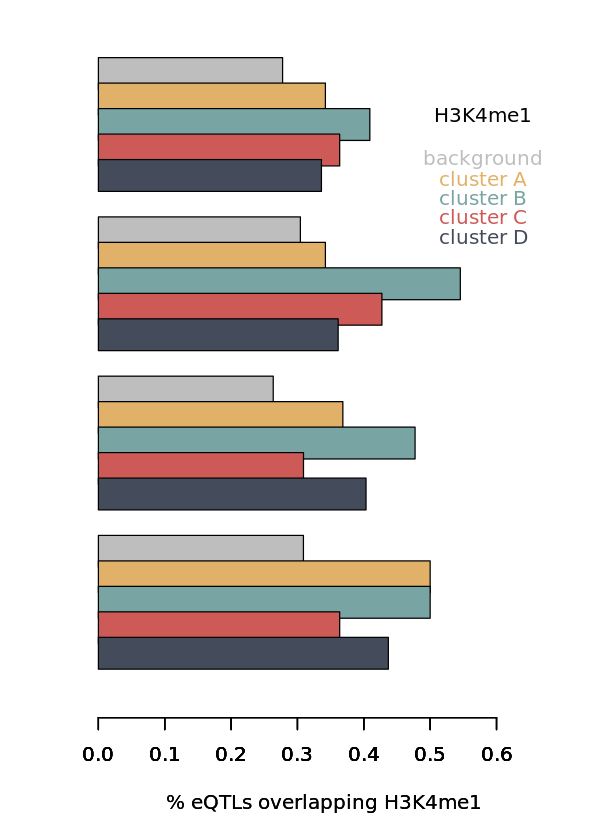

In [103]:
cluster0.ac = get_colsums(cluster0, "H3K4me1")
cluster1.ac = get_colsums(cluster1, "H3K4me1")
cluster2.ac = get_colsums(cluster2, "H3K4me1")
cluster3.ac = get_colsums(cluster3, "H3K4me1")
pseudo.linear.nonsign.ac = get_colsums(pseudo.linear.nonsign, "H3K4me1")

options(repr.plot.width = 5, repr.plot.height = 7)
non <- c(pseudo.linear.nonsign.ac[1],pseudo.linear.nonsign.ac[3],pseudo.linear.nonsign.ac[5],pseudo.linear.nonsign.ac[6])
h0 <- c(cluster0.ac[1], cluster0.ac[3], cluster0.ac[5], cluster0.ac[6])
h72 <- c(cluster1.ac[1], cluster1.ac[3], cluster1.ac[5], cluster1.ac[6])
h48 <- c(cluster2.ac[1], cluster2.ac[3], cluster2.ac[5], cluster2.ac[6])
h24 <- c(cluster3.ac[1], cluster3.ac[3], cluster3.ac[5], cluster3.ac[6])

xmax = 0.68
xtext = 0.58

my.xlim = c(0, xmax)
my.space = 4

barplot(as.numeric(non), 
#         border = "#344d90", 
        col = "grey",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K4me1", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = col0,
        xlim = my.xlim, ylim = c(0.4,9.4), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K4me1", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = col2,
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = col3,
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = col1,
        ylim = c(1.6, 10.6), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(xtext, 10.7, "H3K4me1", col = "black")
text(xtext, 10, "background", col = "grey")
text(xtext, 9.7, "cluster A", col = col0)
text(xtext, 9.4, "cluster B", col = col2)
text(xtext, 9.1, "cluster C", col = col3)
text(xtext, 8.8, "cluster D", col = col1)

In [26]:
cluster0.ac = get_colsums(cluster0, "H3K27ac")
cluster1.ac = get_colsums(cluster1, "H3K27ac")
cluster2.ac = get_colsums(cluster2, "H3K27ac")
cluster3.ac = get_colsums(cluster3, "H3K27ac")
pseudo.linear.nonsign.ac = get_colsums(pseudo.linear.nonsign, "H3K27ac")

options(repr.plot.width = 5, repr.plot.height = 7)
non <- c(pseudo.linear.nonsign.ac[1],pseudo.linear.nonsign.ac[3],pseudo.linear.nonsign.ac[5],pseudo.linear.nonsign.ac[6])
h0 <- c(cluster0.ac[1], cluster0.ac[3], cluster0.ac[5], cluster0.ac[6])
h72 <- c(cluster1.ac[1], cluster1.ac[3], cluster1.ac[5], cluster1.ac[6])
h48 <- c(cluster2.ac[1], cluster2.ac[3], cluster2.ac[5], cluster2.ac[6])
h24 <- c(cluster3.ac[1], cluster3.ac[3], cluster3.ac[5], cluster3.ac[6])

xmax = 0.3
xtext = 0.25

my.xlim = c(0, xmax)
my.space = 4

barplot(as.numeric(non), 
#         border = "lightgrey", 
        col = "grey",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27ac", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = col0,
        xlim = my.xlim, ylim = c(0.4,9.4), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27ac", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = col2,
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = col3,
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = col1,
        ylim = c(1.6, 10.6), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

text(xtext, 10.5, "H3K27ac", col = "black")
text(xtext, 9.4, "background", col = "grey")
text(xtext, 9, "cluster A", col = col0)
text(xtext, 8.6, "cluster B", col = col2)
text(xtext, 8.2, "cluster C", col = col3)
text(xtext, 7.8, "cluster D", col = col1)

ERROR: Error in inner_join(eqtls.set, df.histones, by = c("snp_id", "gene_id")): object 'pseudo.linear.nonsign' not found


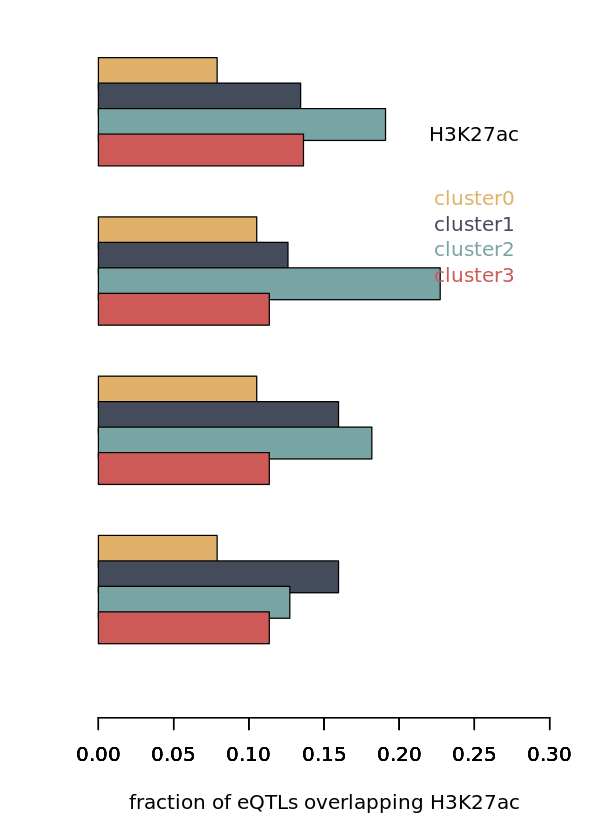

In [27]:
cluster0.ac = get_colsums(cluster0, "H3K27ac")
cluster1.ac = get_colsums(cluster1, "H3K27ac")
cluster2.ac = get_colsums(cluster2, "H3K27ac")
cluster3.ac = get_colsums(cluster3, "H3K27ac")

options(repr.plot.width = 5, repr.plot.height = 7)
h0 <- c(cluster0.ac[1], cluster0.ac[3], cluster0.ac[5], cluster0.ac[6])
h24 <- c(cluster1.ac[1], cluster1.ac[3], cluster1.ac[5], cluster1.ac[6])
h48 <- c(cluster2.ac[1], cluster2.ac[3], cluster2.ac[5], cluster2.ac[6])
h72 <- c(cluster3.ac[1], cluster3.ac[3], cluster3.ac[5], cluster3.ac[6])

my.xlim = c(0,0.3)
my.space = 4

barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = col0,
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "fraction of eQTLs overlapping H3K27ac", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = col1,
        ylim = c(0.4, 9.4), xlim = my.xlim, ylab = "", main = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)

par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = col2,
        ylim = c(0.8, 9.8), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = col3,
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(0.25, 10, "H3K27ac", col = "black")
# text(0.5, 9, "h0", col = "#344d90")
# text(0.5, 8.6, "h24", col = "#5cc5ef")
# text(0.5, 8.2, "h48", col = "#ffb745")
# text(0.5, 7.8, "h72", col = "#e7552c")
text(0.25, 9, "cluster0", col = col0)
text(0.25, 8.6, "cluster1", col = col1)
text(0.25, 8.2, "cluster2", col = col2)
text(0.25, 7.8, "cluster3", col = col3)

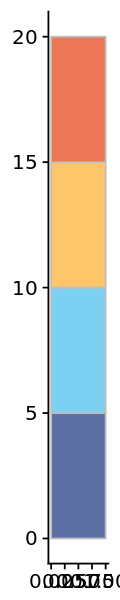

In [28]:
options(repr.plot.width = 1, repr.plot.height = 5)
col_day0 = "#344d90"
col_day1 = "#5cc5ef"
col_day2 = "#ffb745"
col_day3 = "#e7552c"
p = ggplot()
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 0, ymax = 5), color = "grey", alpha = 0.8, fill = col_day0)
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 5, ymax = 10), color = "grey", alpha = 0.8, fill = col_day1)
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 10, ymax = 15), color = "grey", alpha = 0.8, fill = col_day2)
p = p + geom_rect(mapping = aes(xmin = 0, xmax = 1, ymin = 15, ymax = 20), color = "grey", alpha = 0.8, fill = col_day3)
p

In [ ]:
# rect(0, 15, 2, 20, col = col0, border = "white")
# rect(0, 10, 2, 15, col = col1, border = "white")
# rect(0, 5, 2, 10, col = col2, border = "white")
# rect(0, 0, 2, 5, col = col3, border = "white")

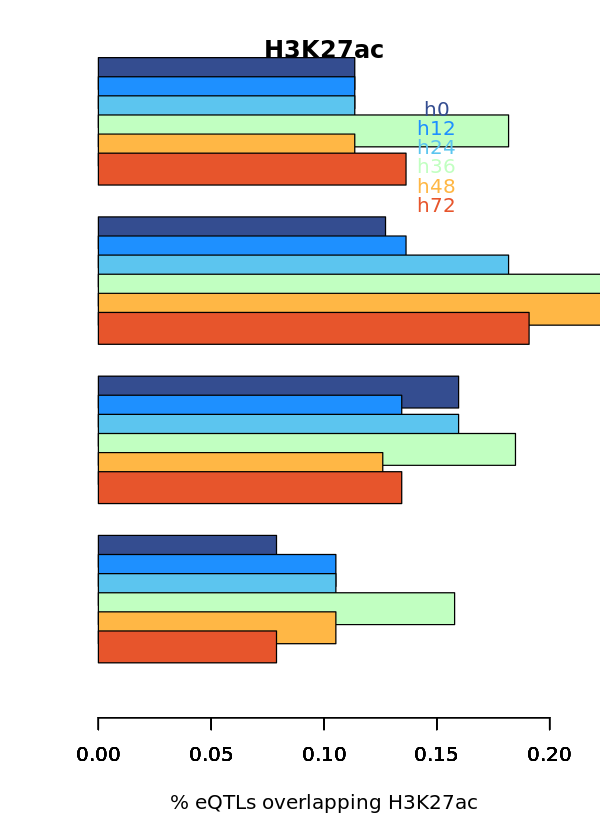

In [29]:
cluster0.ac = get_colsums(cluster0, "H3K27ac")
cluster1.ac = get_colsums(cluster1, "H3K27ac")
cluster2.ac = get_colsums(cluster2, "H3K27ac")
cluster3.ac = get_colsums(cluster3, "H3K27ac")

options(repr.plot.width = 5, repr.plot.height = 7)
h0 <- c(cluster0.ac[1], cluster1.ac[1], cluster2.ac[1], cluster3.ac[1])
h12 <- c(cluster0.ac[2], cluster1.ac[2], cluster2.ac[2], cluster3.ac[2])
h24 <- c(cluster0.ac[3], cluster1.ac[3], cluster2.ac[3], cluster3.ac[3])
h36 <- c(cluster0.ac[4], cluster1.ac[4], cluster2.ac[4], cluster3.ac[4])
h48 <- c(cluster0.ac[5], cluster1.ac[5], cluster2.ac[5], cluster3.ac[5])
h72 <- c(cluster0.ac[6], cluster1.ac[6], cluster2.ac[6], cluster3.ac[6])

my.xlim = c(0,0.2)
my.space = 4

barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = "#344d90",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27ac", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h12,  
#         border = "", 
        col = "dodgerblue",
        ylim = c(0.3, 9.3), xlim = my.xlim, ylab = "", 
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = "#5cc5ef",
        ylim = c(0.6, 9.6), xlim = my.xlim, ylab = "", main = "H3K27ac",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h36,  
#         border = "", 
        col = "darkseagreen1",
        ylim = c(0.9, 9.9), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = "#ffb745",
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = "#e7552c",
        ylim = c(1.5, 10.5), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(0.15, 10.7, "h0", col = "#344d90")
text(0.15, 10.4, "h12", col = "dodgerblue")
text(0.15, 10.1, "h24", col = "#5cc5ef")
text(0.15, 9.8, "h36", col = "darkseagreen1")
text(0.15, 9.5, "h48", col = "#ffb745")
text(0.15, 9.2, "h72", col = "#e7552c")

In [30]:
get_sign <- function(test, myfact){
    res = test
    res = res[res$n_cells > 500,]
    res = res[!(is.na(res$pval)),]
    res$corr_pval = p.adjust(res$pval, method = "BH")
    res[res$corr_pval < 0.1 & res$factor == myfact,]
} 

In [31]:
get_nonsign <- function(test, myfact){
    res = test
    res = res[res$n_cells > 500,]
    res = res[!(is.na(res$pval)),]
    res$corr_pval = p.adjust(res$pval, method = "BH")
    res[res$corr_pval > 0.1 & res$factor == myfact,]
} 

In [32]:
pseudo.linear.sign = get_sign(test, "pseudotime")
pseudo.linear.nonsign = get_nonsign(test, "pseudotime")
pseudo.quadratic.sign = get_sign(quadratic, "pseudotime")

In [33]:
gene_info_filename = "/nfs/leia/research/stegle/dseaton/genomes/hg19/annotation/Homo_sapiens.GRCh37.75.genes.bed"
gene_info = read.table(gene_info_filename)
colnames(gene_info) = c("chromosome_name","start_position","end_position","ensembl_gene_id","gene_biotype","strand")
head(gene_info)

chromosome_name,start_position,end_position,ensembl_gene_id,gene_biotype,strand
1,11868,14412,ENSG00000223972,pseudogene,+
1,14362,29806,ENSG00000227232,pseudogene,-
1,29553,31109,ENSG00000243485,lincRNA,+
1,34553,36081,ENSG00000237613,lincRNA,-
1,52472,54936,ENSG00000268020,pseudogene,+
1,62947,63887,ENSG00000240361,pseudogene,+


In [34]:
add_TSS_dist <- function(test){
    res = inner_join(test, gene_info, by = "ensembl_gene_id")  
    snp_info = as_data_frame(do.call("rbind", lapply(strsplit(res$snp_id, "_"), function(x) t(as.data.frame(x)))))
    colnames(snp_info) = c("chrom","pos","ref_allele","alt_allele")
    res = cbind(res,snp_info)
    res$pos = as.numeric(res$pos)                                       
    res[res$strand == "+","TSS"] = res[res$strand == "+","start_position"]
    res[res$strand == "-","TSS"] = res[res$strand == "-","end_position"]
    res[res$strand == "+","dist"] = res[res$strand == "+","pos"] - res[res$strand == "+","TSS"]
    res[res$strand == "-","dist"] = - res[res$strand == "-","pos"] + res[res$strand == "-","TSS"]
    res
}

In [35]:
pseudo.linear.sign = add_TSS_dist(pseudo.linear.sign)
pseudo.linear.nonsign = add_TSS_dist(pseudo.linear.nonsign)
pseudo.quadratic.sign = add_TSS_dist(pseudo.quadratic.sign)
head(pseudo.linear.nonsign)
# dim(pseudo.linear.sign)

ensembl_gene_id,snp_id,coef,pval,n_cells,index,mean_ase,factor,corr_pval,chromosome_name,start_position,end_position,gene_biotype,strand,chrom,pos,ref_allele,alt_allele,TSS,dist
ENSG00000083642,13_33177572_T_G,0.03132758,0.01366340,12859,"('ENSG00000083642', '13_33177572_T_G')",0.3951996,pseudotime,0.1003585,13,33160563,33352157,protein_coding,+,13,33177572,T,G,33160563,17009
ENSG00000104472,8_141501019_G_A,-0.04608461,0.01368507,6215,"('ENSG00000104472', '8_141501019_G_A')",0.4510236,pseudotime,0.1004756,8,141521396,141527236,protein_coding,+,8,141501019,G,A,141521396,-20377
ENSG00000204237,17_79614134_T_C,0.07303150,0.01370126,2322,"('ENSG00000204237', '17_79614134_T_C')",0.4429899,pseudotime,0.1005024,17,79632065,79633665,protein_coding,-,17,79614134,T,C,79633665,19531
ENSG00000177683,7_108179726_G_C,0.02955157,0.01372560,10746,"('ENSG00000177683', '7_108179726_G_C')",0.2098717,pseudotime,0.1005024,7,108194986,108210194,protein_coding,-,7,108179726,G,C,108210194,30468
ENSG00000143198,1_165599649_C_T,0.03916195,0.01372846,6944,"('ENSG00000143198', '1_165599649_C_T')",0.5145417,pseudotime,0.1005024,1,165600097,165631033,protein_coding,+,1,165599649,C,T,165600097,-448
ENSG00000180185,16_1906352_G_A,0.03150856,0.01372883,11884,"('ENSG00000180185', '16_1906352_G_A')",0.4144667,pseudotime,0.1005024,16,1876967,1890208,protein_coding,+,16,1906352,G,A,1876967,29385


In [36]:
res = pseudo.linear.sign
res[res$mean_ase > 0.5 & res$coef > 0, "direction"] = "+"
res[res$mean_ase < 0.5 & res$coef < 0, "direction"] = "+"
res[res$mean_ase > 0.5 & res$coef < 0, "direction"] = "-"
res[res$mean_ase < 0.5 & res$coef > 0, "direction"] = "-"
pseudo.linear.sign = res

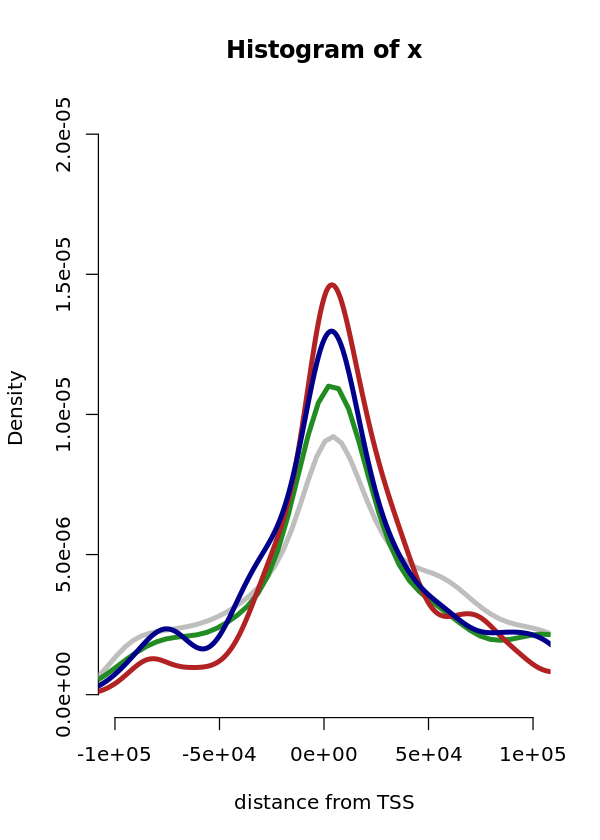

In [37]:
x = pseudo.linear.nonsign$dist
col = "grey"
hist(x, breaks = 1000, border = "white", probability = T, xlim = c(min(x),-min(x)), col = "white",
    xlab = "distance from TSS")
lines(density(x), col = col, lwd = 4)
x = pseudo.linear.sign[pseudo.linear.sign$direction == "+",]$dist
col = "forestgreen"
lines(density(x), col = col, lwd = 4)
x = pseudo.linear.sign[pseudo.linear.sign$direction == "-",]$dist
col = "firebrick"
lines(density(x), col = col, lwd = 4)
x = pseudo.quadratic.sign$dist
col = "darkblue"
lines(density(x), col = col, lwd = 4)

In [38]:
eQTL_histones_filename <- "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/qtl_chipseq_overlaps/all_qtl_results_combined.overlap_w_vallier_histone_marks.tsv"
eQTL_histones <- read.csv(eQTL_histones_filename, sep = "\t")
head(eQTL_histones)

snp_id,Unnamed..0,beta.mean,beta_se,empirical_feature_p_value,p_value.mean,snp_id.1,feature,global_corr_p_value,chrom,⋯,H3K4me3,H3K4me3_h0,H3K4me3_h24,H3K36me3_h48,H3K36me3_h24,H3K36me3_h36,H3K36me3_h72,H3K36me3_h0,H3K36me3_h12,H3K36me3
6_31132414_G_A,24,-1.386281,0.1083733,1.592971e-18,1.823854e-37,6_31132414_G_A,ENSG00000204531_POU5F1,5.264237e-16,6,⋯,False,False,False,True,True,True,True,True,True,True
6_32634922_A_G,117,-1.270786,0.1469673,1.977147e-11,5.299864e-18,6_32634922_A_G,ENSG00000179344_HLA-DQB1,1.340269e-09,6,⋯,False,False,False,False,False,False,False,False,False,False
6_32634922_A_G,1879,-1.375988,0.1478612,8.485500e-15,1.328104e-20,6_32634922_A_G,ENSG00000179344_HLA-DQB1,1.519887e-12,6,⋯,False,False,False,False,False,False,False,False,False,False
6_32634922_A_G,3587,-1.438379,0.1499301,3.298243e-12,8.500689e-22,6_32634922_A_G,ENSG00000179344_HLA-DQB1,5.981274e-10,6,⋯,False,False,False,False,False,False,False,False,False,False
9_136227260_A_G,20,-1.371767,0.1094063,1.461609e-19,4.608624e-36,9_136227260_A_G,ENSG00000148291_SURF2,5.796154e-17,9,⋯,False,False,False,True,True,True,True,True,True,True
9_136227260_A_G,1851,-1.410832,0.1143974,6.363028e-20,6.036677e-35,9_136227260_A_G,ENSG00000148291_SURF2,2.949861e-17,9,⋯,False,False,False,True,True,True,True,True,True,True


In [39]:
df.histones = eQTL_histones[, colnames(eQTL_histones) %in% c(colnames(eQTL_histones)[grep("H3K27ac_h",colnames(eQTL_histones))],
                                                                 colnames(eQTL_histones)[grep("H3K4me1_h",colnames(eQTL_histones))],
                                                            "snp_id","feature")]
df.histones$ensembl_gene_id = gsub("*_.*", "", df.histones$feature)
df.histones$eQTL = paste0(df.histones$feature,"-",df.histones$snp_id)
df.histones = df.histones[-which(duplicated(df.histones$eQTL)),]
nrow(df.histones)
head(df.histones)

[1] 4470

,snp_id,feature,H3K27ac_h12,H3K27ac_h0,H3K27ac_h48,H3K27ac_h72,H3K27ac_h24,H3K27ac_h36,H3K4me1_h0,H3K4me1_h36,H3K4me1_h24,H3K4me1_h12,H3K4me1_h48,H3K4me1_h72,ensembl_gene_id,eQTL
1,6_31132414_G_A,ENSG00000204531_POU5F1,False,False,False,False,False,False,True,True,True,True,True,True,ENSG00000204531,ENSG00000204531_POU5F1-6_31132414_G_A
2,6_32634922_A_G,ENSG00000179344_HLA-DQB1,False,False,False,False,False,False,False,False,False,False,False,False,ENSG00000179344,ENSG00000179344_HLA-DQB1-6_32634922_A_G
5,9_136227260_A_G,ENSG00000148291_SURF2,False,False,False,False,False,False,True,True,True,True,True,True,ENSG00000148291,ENSG00000148291_SURF2-9_136227260_A_G
8,16_31522723_T_C,ENSG00000169877_AHSP,False,False,False,False,False,False,False,False,False,False,False,False,ENSG00000169877,ENSG00000169877_AHSP-16_31522723_T_C
9,12_7945196_G_T,ENSG00000176654_NANOGP1,False,False,False,False,False,False,True,True,True,True,True,True,ENSG00000176654,ENSG00000176654_NANOGP1-12_7945196_G_T
10,10_122218993_G_A,ENSG00000203805_PPAPDC1A,False,False,True,True,False,True,False,True,True,True,True,True,ENSG00000203805,ENSG00000203805_PPAPDC1A-10_122218993_G_A


In [40]:
get_colsums <- function(eqtls.set, hist.mark){
    res.all = inner_join(eqtls.set, df.histones, by = c("snp_id","ensembl_gene_id"))
    res = res.all[, grep(hist.mark, colnames(res.all))]
    res[res == "True"] = 1
    res[res == "False"] = 0
    df = as.data.frame(sapply(res, as.numeric))
    colsums = colSums(df)/nrow(df)
    colsums[order(names(colsums))]
}

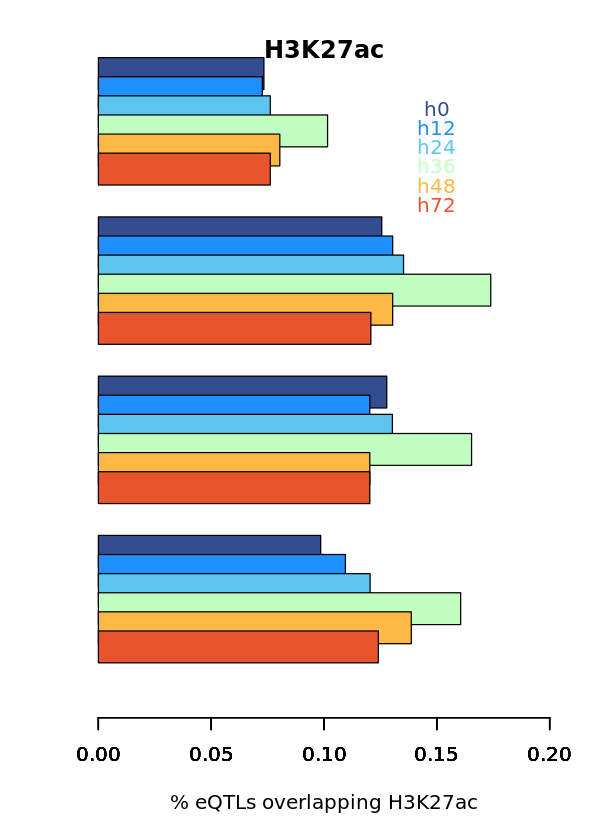

In [41]:
pos.lin.ac = get_colsums(pseudo.linear.sign[pseudo.linear.sign$direction == "+",], "H3K27ac")
neg.lin.ac = get_colsums(pseudo.linear.sign[pseudo.linear.sign$direction == "-",], "H3K27ac")
quad.ac = get_colsums(pseudo.quadratic.sign, "H3K27ac")
non.sign.ac = get_colsums(pseudo.linear.nonsign, "H3K27ac")

options(repr.plot.width = 5, repr.plot.height = 7)
h0 <- c(pos.lin.ac[1], neg.lin.ac[1], quad.ac[1], non.sign.ac[1])
h12 <- c(pos.lin.ac[2], neg.lin.ac[2], quad.ac[2], non.sign.ac[2])
h24 <- c(pos.lin.ac[3], neg.lin.ac[3], quad.ac[3], non.sign.ac[3])
h36 <- c(pos.lin.ac[4], neg.lin.ac[4], quad.ac[4], non.sign.ac[4])
h48 <- c(pos.lin.ac[5], neg.lin.ac[5], quad.ac[5], non.sign.ac[5])
h72 <- c(pos.lin.ac[6], neg.lin.ac[6], quad.ac[6], non.sign.ac[6])

my.xlim = c(0,0.2)
my.space = 4

barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = "#344d90",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "", 
        width = 0.5, xlab = "% eQTLs overlapping H3K27ac", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h12,  
#         border = "", 
        col = "dodgerblue",
        ylim = c(0.3, 9.3), xlim = my.xlim, ylab = "", 
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = "#5cc5ef",
        ylim = c(0.6, 9.6), xlim = my.xlim, ylab = "", main = "H3K27ac",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h36,  
#         border = "", 
        col = "darkseagreen1",
        ylim = c(0.9, 9.9), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = "#ffb745",
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = "#e7552c",
        ylim = c(1.5, 10.5), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(0.15, 10.7, "h0", col = "#344d90")
text(0.15, 10.4, "h12", col = "dodgerblue")
text(0.15, 10.1, "h24", col = "#5cc5ef")
text(0.15, 9.8, "h36", col = "darkseagreen1")
text(0.15, 9.5, "h48", col = "#ffb745")
text(0.15, 9.2, "h72", col = "#e7552c")

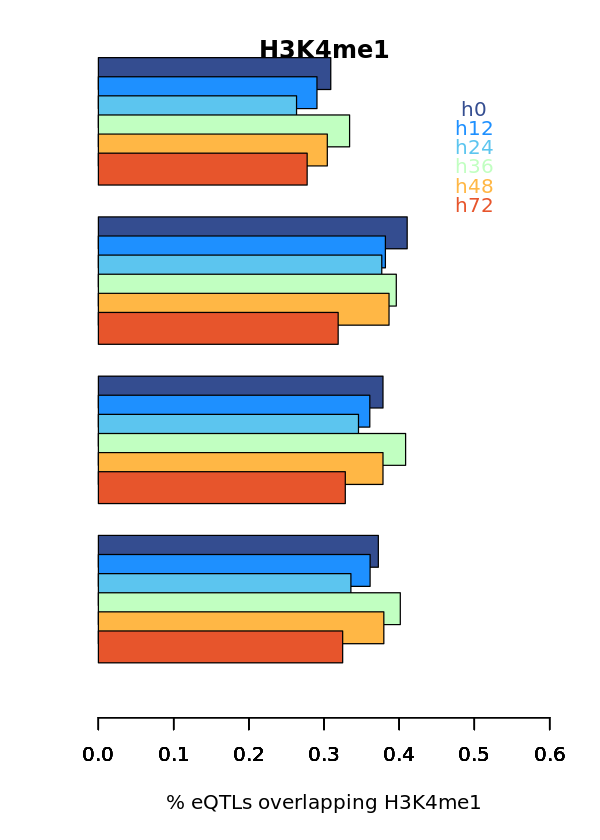

In [42]:
pos.lin.me = get_colsums(pseudo.linear.sign[pseudo.linear.sign$direction == "+",], "H3K4me1")
neg.lin.me = get_colsums(pseudo.linear.sign[pseudo.linear.sign$direction == "-",], "H3K4me1")
quad.me = get_colsums(pseudo.quadratic.sign, "H3K4me1")
non.sign.me = get_colsums(pseudo.linear.nonsign, "H3K4me1")

options(repr.plot.width = 5, repr.plot.height = 7)
h0 <- c(pos.lin.me[1], neg.lin.me[1], quad.me[1], non.sign.me[1])
h12 <- c(pos.lin.me[2], neg.lin.me[2], quad.me[2], non.sign.me[2])
h24 <- c(pos.lin.me[3], neg.lin.me[3], quad.me[3], non.sign.me[3])
h36 <- c(pos.lin.me[4], neg.lin.me[4], quad.me[4], non.sign.me[4])
h48 <- c(pos.lin.me[5], neg.lin.me[5], quad.me[5], non.sign.me[5])
h72 <- c(pos.lin.me[6], neg.lin.me[6], quad.me[6], non.sign.me[6])

my.xlim = c(0,0.6)
my.space = 4

barplot(as.numeric(h0), 
#         border = "#344d90", 
        col = "#344d90",
        xlim = my.xlim, ylim = c(0,9), space = my.space, ylab = "",  main = "H3K4me1",
        width = 0.5, xlab = "% eQTLs overlapping H3K4me1", horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h12,  
#         border = "", 
        col = "dodgerblue",
        ylim = c(0.3, 9.3), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h24,  
#         border = "", 
        col = "#5cc5ef",
        ylim = c(0.6, 9.6), xlim = my.xlim, ylab = "", 
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h36,  
#         border = "", 
        col = "darkseagreen1",
        ylim = c(0.9, 9.9), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h48,  
#         border = "", 
        col = "#ffb745",
        ylim = c(1.2, 10.2), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
par(new = TRUE)
barplot(h72,  
#         border = "", 
        col = "#e7552c",
        ylim = c(1.5, 10.5), xlim = my.xlim, ylab = "",
        width = 0.5, space = my.space, axisnames = FALSE, horiz = TRUE, las = 1)
text(0.5, 10.7, "h0", col = "#344d90")
text(0.5, 10.4, "h12", col = "dodgerblue")
text(0.5, 10.1, "h24", col = "#5cc5ef")
text(0.5, 9.8, "h36", col = "darkseagreen1")
text(0.5, 9.5, "h48", col = "#ffb745")
text(0.5, 9.2, "h72", col = "#e7552c")

In [104]:
clusters_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/tables_for_anna_Aug2019/dynamic_eqtl_heatmaps/cluster_info.tsv"
clusters = read.csv(clusters_filename, sep = "\t")
head(clusters,2)

gene_id,snp_id,exp_cluster_label,ase_cluster_label
ENSG00000035141,2_70502930_A_G,1,1
ENSG00000066654,16_20736906_G_A,1,1


In [45]:
gtex_tagging_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/qtl_annotation/all_results_combined.tsv.all_gtex_gwas_tagging_annotations.hipsci_ref.txt"

gtex_tagging = read.csv(gtex_tagging_filename, sep = "\t")

gtex_tagging$how_many_tissues = 0
for (i in 1:nrow(gtex_tagging)){
    gtex_tagging$how_many_tissues[i] = sum(gsub("-","0",gsub("\\}","",gsub("\\{","",gtex_tagging[i,grep("LD",colnames(gtex_tagging))])))>0)
}

In [46]:
gtex_tagging$ensembl_gene_id = gtex_tagging$gene_id

In [47]:
# get_sign <- function(test, myfact, fdr){
#     res = test
#     res = res[res$n_cells > 500,]
#     res = res[!(is.na(res$pval)),]
#     res$corr_pval = p.adjust(res$pval, method = "BH")
#     res[res$corr_pval < fdr & res$factor == myfact,]
# } 

In [48]:
# pseudo.linear.sign = get_sign(test, "pseudotime", 0.1)
# pseudo.quadratic.sign = get_sign(quadratic, "pseudotime", 0.1)
# pseudo_inters = rbind(pseudo.linear.sign, pseudo.quadratic.sign)
# head(pseudo_inters)

In [49]:
new_folder = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/tables_for_anna_Aug2019/ase_interaction_results/"
test_filename = paste0(new_folder,"pseudotimeandmodules.pseudotime_2dof_test.all_leads.multitest_corrected.tsv")
test = read.csv(test_filename, sep = "\t")

In [50]:
get_sign <- function(test, myfact){
    res = test
    res = res[res$n_cells > 50,]
    res = res[!(is.na(res$pval)),]
    res[res$qval < 0.1 & res$factor == myfact,]
} 

In [51]:
pseudo_inters = get_sign(test, "pseudotime")

In [52]:
gtex_tagging$eqtls = paste0(gtex_tagging$gene_id, "-", gtex_tagging$snp_id)
length(unique(gtex_tagging$eqtls))
length(unique(gtex_tagging[gtex_tagging$stage_specific == 'True',"eqtls"]))

[1] 4422

[1] 1098

In [53]:
head(pseudo_inters,2)

ensembl_gene_id,snp_id,pval,n_cells,factor,qval
ENSG00000142089,11_320394_C_T,6.053215e-275,21955,pseudotime,2.404337e-271
ENSG00000120675,13_43597706_C_T,1.582229e-266,13767,pseudotime,3.142307e-263


In [54]:
gtex_tagging$ensembl_gene_id = gsub("_.*","",gtex_tagging$feature)
head(gtex_tagging,1)

feature,snp_id,stage,beta.mean,beta_se,empirical_feature_p_value,p_value.mean,global_corr_p_value,snp_chromosome,snp_position,⋯,Vagina_LD,Whole_Blood_Variant,Whole_Blood_Annotation,Whole_Blood_LD,ipsc_hipsci_eqtls_mirauta2018_Variant,ipsc_hipsci_eqtls_mirauta2018_Annotation,ipsc_hipsci_eqtls_mirauta2018_LD,how_many_tissues,eqtls,ensembl_gene_id
ENSG00000204531_POU5F1,6_31132414_G_A,ips,-1.386281,0.1083733,1.592971e-18,1.823854e-37,5.264237e-16,6,31132414,⋯,-,-,-,-,{6_31132414},{6_31132414_G_A-ENSG00000204531},{0.9999999999999999},33,-6_31132414_G_A,ENSG00000204531


In [55]:
eqtls_dynamic = inner_join(pseudo_inters, gtex_tagging, by = c("ensembl_gene_id","snp_id"))

In [56]:
eqtls_dynamic$eqtls = paste0(eqtls_dynamic$gene_id, "-", eqtls_dynamic$snp_id)
length(unique(eqtls_dynamic$eqtls))
length(unique(eqtls_dynamic[eqtls_dynamic$stage_specific == 'True',"eqtls"]))

[1] 868

[1] 119

In [57]:
gtex_tagging$gene_id = gsub("*_.*", "", gtex_tagging$feature)
gtex_dynamic = inner_join(clusters, gtex_tagging, by = c("gene_id","snp_id"))

In [58]:
nrow(gtex_tagging)
sum(gtex_tagging$stage_specific == 'True')

[1] 4824

[1] 1100

In [59]:
gtex_dynamic$eqtls = paste0(gtex_dynamic$gene_id, "-", gtex_dynamic$snp_id)
length(unique(gtex_dynamic$eqtls))
length(unique(gtex_dynamic[gtex_dynamic$stage_specific == 'True',"eqtls"]))
length(unique(gtex_dynamic$eqtls))-length(unique(gtex_dynamic[gtex_dynamic$stage_specific == 'True',"eqtls"]))

[1] 300

[1] 55

[1] 245

In [60]:
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips",])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label %in% c('1'),])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '3',])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '2',])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '0',])

[1] 21

[1] 12

[1] 3

[1] 4

[1] 2

In [61]:
cols = c("#444c5c","#ce5a57","#78a5a3","#e1b16a")

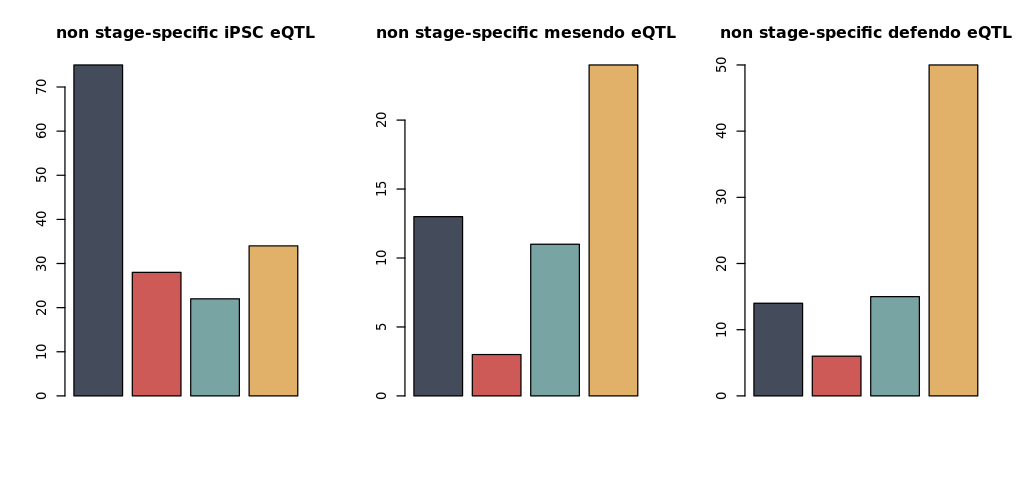

In [62]:
par(mfrow = c(1,3))
options(repr.plot.width = 8.5, repr.plot.height = 4)
barplot(c(nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '1',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '3',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '2',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '0',])), col = cols,
       main = "non stage-specific iPSC eQTL")
barplot(c(nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '1',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '3',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '2',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '0',])), col = cols, 
        main = "non stage-specific mesendo eQTL")
barplot(c(nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '1',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '3',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '2',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'False' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '0',])), col = cols,
       main = "non stage-specific defendo eQTL")

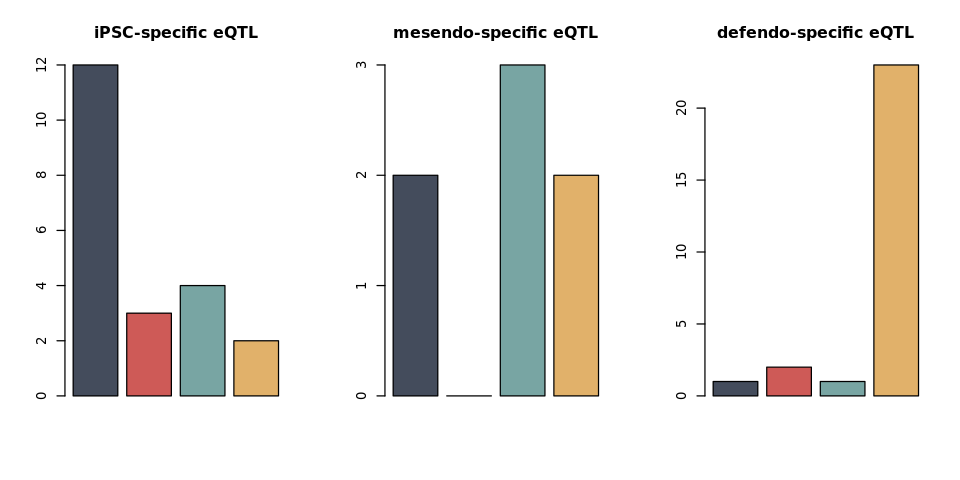

In [63]:
par(mfrow = c(1,3))
options(repr.plot.width = 8, repr.plot.height = 4)
barplot(c(nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '1',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '3',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '2',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "ips" & 
                  gtex_dynamic$ase_cluster_label == '0',])), col = cols,
       main = "iPSC-specific eQTL")
barplot(c(nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '1',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '3',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '2',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '0',])), col = cols, 
        yaxt = 'n', main = "mesendo-specific eQTL")
axis(side = 2, at = c(0,1,2,3))
barplot(c(nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '1',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '3',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '2',]),
         nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '0',])), col = cols,
       main = "defendo-specific eQTL")

In [64]:
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo",])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label %in% c('0'),])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '2',])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '3',])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "mesendo" & 
                  gtex_dynamic$ase_cluster_label == '1',])

[1] 7

[1] 2

[1] 3

[1] 0

[1] 2

In [65]:
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo",])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label %in% c('0'),])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '2',])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '3',])
nrow(gtex_dynamic[gtex_dynamic$stage_specific == 'True' & gtex_dynamic$stage == "defendo" & 
                  gtex_dynamic$ase_cluster_label == '1',])

[1] 27

[1] 23

[1] 1

[1] 2

[1] 1

In [66]:
head(gtex_tagging)

feature,snp_id,stage,beta.mean,beta_se,empirical_feature_p_value,p_value.mean,global_corr_p_value,snp_chromosome,snp_position,⋯,Whole_Blood_Variant,Whole_Blood_Annotation,Whole_Blood_LD,ipsc_hipsci_eqtls_mirauta2018_Variant,ipsc_hipsci_eqtls_mirauta2018_Annotation,ipsc_hipsci_eqtls_mirauta2018_LD,how_many_tissues,eqtls,ensembl_gene_id,gene_id
ENSG00000204531_POU5F1,6_31132414_G_A,ips,-1.386281,0.1083733,1.592971e-18,1.823854e-37,5.264237e-16,6,31132414,⋯,-,-,-,{6_31132414},{6_31132414_G_A-ENSG00000204531},{0.9999999999999999},33,-6_31132414_G_A,ENSG00000204531,ENSG00000204531
ENSG00000179344_HLA-DQB1,6_32634922_A_G,ips,-1.270786,0.1469673,1.977147e-11,5.299864e-18,1.340269e-09,6,32634922,⋯,{6_32608508};{6_32526526};{6_32627082};{6_32607558},{6_32608508_A_T_b37-ENSG00000196735};{6_32526526_A_G_b37-ENSG00000198502};{6_32627082_A_G_b37-ENSG00000223534};{6_32607558_A_G_b37-ENSG00000232629},{0.4062001050131084};{0.36551405659243374};{0.7164536068532416};{0.2915903443713935},-,-,-,49,-6_32634922_A_G,ENSG00000179344,ENSG00000179344
ENSG00000179344_HLA-DQB1,6_32634922_A_G,mesendo,-1.375988,0.1478612,8.485500e-15,1.328104e-20,1.519887e-12,6,32634922,⋯,{6_32608508};{6_32526526};{6_32627082};{6_32607558},{6_32608508_A_T_b37-ENSG00000196735};{6_32526526_A_G_b37-ENSG00000198502};{6_32627082_A_G_b37-ENSG00000223534};{6_32607558_A_G_b37-ENSG00000232629},{0.4062001050131084};{0.36551405659243374};{0.7164536068532416};{0.2915903443713935},-,-,-,49,-6_32634922_A_G,ENSG00000179344,ENSG00000179344
ENSG00000179344_HLA-DQB1,6_32634922_A_G,defendo,-1.438379,0.1499301,3.298243e-12,8.500689e-22,5.981274e-10,6,32634922,⋯,{6_32608508};{6_32526526};{6_32627082};{6_32607558},{6_32608508_A_T_b37-ENSG00000196735};{6_32526526_A_G_b37-ENSG00000198502};{6_32627082_A_G_b37-ENSG00000223534};{6_32607558_A_G_b37-ENSG00000232629},{0.4062001050131084};{0.36551405659243374};{0.7164536068532416};{0.2915903443713935},-,-,-,49,-6_32634922_A_G,ENSG00000179344,ENSG00000179344
ENSG00000148291_SURF2,9_136227260_A_G,ips,-1.371767,0.1094063,1.461609e-19,4.608624e-36,5.796154e-17,9,136227260,⋯,{9_136205775},{9_136205775_T_C_b37-ENSG00000148297},{0.5877429781370492},{9_136214955};{9_136227260},{9_136214955_A_G-ENSG00000148297};{9_136227260_A_G-ENSG00000148291},{0.992130602668752};{0.9999999999999999},44,-9_136227260_A_G,ENSG00000148291,ENSG00000148291
ENSG00000148291_SURF2,9_136227260_A_G,mesendo,-1.410832,0.1143974,6.363028e-20,6.036677e-35,2.949861e-17,9,136227260,⋯,{9_136205775},{9_136205775_T_C_b37-ENSG00000148297},{0.5877429781370492},{9_136214955};{9_136227260},{9_136214955_A_G-ENSG00000148297};{9_136227260_A_G-ENSG00000148291},{0.992130602668752};{0.9999999999999999},44,-9_136227260_A_G,ENSG00000148291,ENSG00000148291


In [67]:
gwas_tagging = gtex_tagging[gtex_tagging$GWAS_LD != "-",]
nrow(gwas_tagging)
head(gwas_tagging)

[1] 610

,feature,snp_id,stage,beta.mean,beta_se,empirical_feature_p_value,p_value.mean,global_corr_p_value,snp_chromosome,snp_position,⋯,Whole_Blood_Variant,Whole_Blood_Annotation,Whole_Blood_LD,ipsc_hipsci_eqtls_mirauta2018_Variant,ipsc_hipsci_eqtls_mirauta2018_Annotation,ipsc_hipsci_eqtls_mirauta2018_LD,how_many_tissues,eqtls,ensembl_gene_id,gene_id
2,ENSG00000179344_HLA-DQB1,6_32634922_A_G,ips,-1.2707861,0.1469673,1.977147e-11,5.299864e-18,1.340269e-09,6,32634922,⋯,{6_32608508};{6_32526526};{6_32627082};{6_32607558},{6_32608508_A_T_b37-ENSG00000196735};{6_32526526_A_G_b37-ENSG00000198502};{6_32627082_A_G_b37-ENSG00000223534};{6_32607558_A_G_b37-ENSG00000232629},{0.4062001050131084};{0.36551405659243374};{0.7164536068532416};{0.2915903443713935},-,-,-,49,-6_32634922_A_G,ENSG00000179344,ENSG00000179344
3,ENSG00000179344_HLA-DQB1,6_32634922_A_G,mesendo,-1.3759876,0.1478612,8.485500e-15,1.328104e-20,1.519887e-12,6,32634922,⋯,{6_32608508};{6_32526526};{6_32627082};{6_32607558},{6_32608508_A_T_b37-ENSG00000196735};{6_32526526_A_G_b37-ENSG00000198502};{6_32627082_A_G_b37-ENSG00000223534};{6_32607558_A_G_b37-ENSG00000232629},{0.4062001050131084};{0.36551405659243374};{0.7164536068532416};{0.2915903443713935},-,-,-,49,-6_32634922_A_G,ENSG00000179344,ENSG00000179344
4,ENSG00000179344_HLA-DQB1,6_32634922_A_G,defendo,-1.4383794,0.1499301,3.298243e-12,8.500689e-22,5.981274e-10,6,32634922,⋯,{6_32608508};{6_32526526};{6_32627082};{6_32607558},{6_32608508_A_T_b37-ENSG00000196735};{6_32526526_A_G_b37-ENSG00000198502};{6_32627082_A_G_b37-ENSG00000223534};{6_32607558_A_G_b37-ENSG00000232629},{0.4062001050131084};{0.36551405659243374};{0.7164536068532416};{0.2915903443713935},-,-,-,49,-6_32634922_A_G,ENSG00000179344,ENSG00000179344
16,ENSG00000254870_ATP6V1G2-DDX39B,6_31486901_T_C,ips,-1.5054851,0.1145010,6.144848e-23,1.742136e-39,4.873599e-20,6,31486901,⋯,{6_31226769};{6_31509372};{6_31646683},{6_31226769_T_C_b37-ENSG00000243753};{6_31509372_G_A_b37-ENSG00000213760};{6_31646683_A_G_b37-ENSG00000213722},{0.20640111692592972};{0.7056191036210315};{0.4129870645272648},{6_31486901},{6_31486901_T_C-ENSG00000198563},{0.9999999999999992},40,-6_31486901_T_C,ENSG00000254870,ENSG00000254870
17,ENSG00000254870_ATP6V1G2-DDX39B,6_31486901_T_C,defendo,-1.2581014,0.1233977,9.515953e-19,2.076756e-24,6.163186e-16,6,31486901,⋯,{6_31226769};{6_31509372};{6_31646683},{6_31226769_T_C_b37-ENSG00000243753};{6_31509372_G_A_b37-ENSG00000213760};{6_31646683_A_G_b37-ENSG00000213722},{0.20640111692592972};{0.7056191036210315};{0.4129870645272648},{6_31486901},{6_31486901_T_C-ENSG00000198563},{0.9999999999999992},40,-6_31486901_T_C,ENSG00000254870,ENSG00000254870
41,ENSG00000145725_PPIP5K2,5_102473141_T_C,ips,0.9848858,0.1067839,6.176528e-17,2.884576e-20,1.224682e-14,5,102473141,⋯,{5_102118079};{5_102407374},{5_102118079_C_T_b37-ENSG00000145730};{5_102407374_G_A_b37-ENSG00000145725},{0.34422006757570456};{0.975212039023744},{5_102352034};{5_102391465},{5_102352034_A_C-ENSG00000145723};{5_102391465_C_T-ENSG00000145725},{0.9491261121014748};{0.9708510558687157},37,-5_102473141_T_C,ENSG00000145725,ENSG00000145725


In [68]:
gwas_tagging$gene_id = gsub("*_.*", "", gwas_tagging$feature)
gwas_dynamic = inner_join(clusters, gwas_tagging, by = c("gene_id","snp_id"))
nrow(gwas_dynamic)

[1] 37

In [69]:
length(unique(gwas_dynamic$feature))

[1] 30

In [70]:
gwas_dynamic[order(gwas_dynamic$GWAS_LD, decreasing = T),c("feature","snp_id","stage","beta.mean","p_value.mean","global_corr_p_value",
                    "GWAS_LD","GWAS_Variant")]

,feature,snp_id,stage,beta.mean,p_value.mean,global_corr_p_value,GWAS_LD,GWAS_Variant
13,ENSG00000131187_F12,5_176841339_T_C,defendo,-0.3439831,3.174729e-04,3.641933e-02,{1.0};{0.9197852929722292};{0.9197852929722292};{0.9086970618984077};{0.9166260177317646},{5_176841339};{5_176839898};{5_176839890};{5_176836532};{5_176842474}
4,ENSG00000124588_NQO2,6_3003970_A_G,ips,-1.0877112,2.627552e-21,2.249982e-11,{1.0},{6_3003970}
5,ENSG00000124588_NQO2,6_3003970_A_G,defendo,-0.8510047,9.971248e-16,2.082157e-10,{1.0},{6_3003970}
3,ENSG00000105793_GTPBP10,7_89977760_A_G,ips,0.3083512,1.485008e-05,2.889887e-02,{0.9999999999999998},{7_89977760}
8,ENSG00000139835_GRTP1,13_114015015_A_G,defendo,0.5137721,3.893592e-08,6.935748e-04,{0.9962613523687008},{13_114016886}
1,ENSG00000140545_MFGE8,15_89443301_G_A,mesendo,-0.6729337,2.911170e-13,1.190423e-06,{0.9956804266987197},{15_89445651}
2,ENSG00000140545_MFGE8,15_89443301_G_A,defendo,-0.5436680,9.364515e-12,8.352166e-08,{0.9956804266987197},{15_89445651}
35,ENSG00000172469_MANEA,6_96033762_T_G,ips,-0.4391191,9.810099e-07,3.127396e-03,{0.9935975175097204},{6_96031111}
36,ENSG00000172469_MANEA,6_96033762_T_G,mesendo,-0.5774525,1.075435e-08,2.229983e-04,{0.9935975175097204},{6_96031111}
21,ENSG00000107798_LIPA,10_91004886_A_G,ips,-0.5295583,2.759715e-12,2.936897e-06,{0.9918865717151631};{0.9637722935126676};{0.9905559661657224};{0.997295199567232};{0.9999999999999999},{10_91003419};{10_91002927};{10_91008879};{10_91004916};{10_91004886}


In [71]:
gwas_dynamic[gwas_dynamic$feature == "ENSG00000197728_RPS26",]

,gene_id,snp_id,exp_cluster_label,ase_cluster_label,feature,stage,beta.mean,beta_se,empirical_feature_p_value,p_value.mean,⋯,Vagina_LD,Whole_Blood_Variant,Whole_Blood_Annotation,Whole_Blood_LD,ipsc_hipsci_eqtls_mirauta2018_Variant,ipsc_hipsci_eqtls_mirauta2018_Annotation,ipsc_hipsci_eqtls_mirauta2018_LD,how_many_tissues,eqtls,ensembl_gene_id
15,ENSG00000197728,12_56401085_G_A,1,0,ENSG00000197728_RPS26,ips,-0.8408477,0.07424087,3.349038e-26,9.762508e-30,⋯,{0.9846248502082993},{12_56435929};{12_56379427},{12_56435929_C_G_b37-ENSG00000197728};{12_56379427_G_C_b37-ENSG00000139531},{0.9846248502082993};{0.8871944798453143},{12_56435929},{12_56435929_C_G-ENSG00000197728},{0.9846248502082993},50,-12_56401085_G_A,ENSG00000197728
16,ENSG00000197728,12_56401085_G_A,1,0,ENSG00000197728_RPS26,defendo,-0.7332921,0.09182302,8.702826e-18,1.394685e-15,⋯,{0.9846248502082993},{12_56435929};{12_56379427},{12_56435929_C_G_b37-ENSG00000197728};{12_56379427_G_C_b37-ENSG00000139531},{0.9846248502082993};{0.8871944798453143},{12_56435929},{12_56435929_C_G-ENSG00000197728},{0.9846248502082993},50,-12_56401085_G_A,ENSG00000197728


In [72]:
gwas_cellfactors = inner_join(clusters, gwas_tagging, by = c("gene_id","snp_id"))
nrow(gwas_dynamic)

[1] 37